# 1. Add project src/ to Python path (so imports like from data_generation import ... work)

In [1]:
# === Initialization Cell – AWS-CapacityForecaster =================================

import sys
import os
from pathlib import Path

# 1. Add project src/ to Python path (so imports like from data_generation import ... work)
PROJECT_ROOT = Path.cwd().resolve().parent.parent if "playground" in str(Path.cwd()) else Path.cwd()
SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

print(f"Project root:   {PROJECT_ROOT}")
print(f"Added to path:  {SRC_PATH}")
print(f"Current dir:    {Path.cwd()}")
print(f"Python version: {sys.version.split('|')[0].strip()}")

Project root:   C:\pyproj\AWS-CapacityForecaster
Added to path:  C:\pyproj\AWS-CapacityForecaster\src
Current dir:    C:\pyproj\AWS-CapacityForecaster\playground\notebooks
Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]


# 2. Core imports for data generation & exploration

In [2]:
# 2. Core imports for data generation & exploration
try:
    from data_generation import generate_full_dataset
    from utils.server_archetypes import ServerArchetype
    from utils.logging_config import setup_logger          # ← FIXED: setup_logger (not setup_logging)
    print("Successfully imported data_generation & utils modules ✓")
except ImportError as e:
    print("Import error — check paths, file names, or typos in import statements.")
    print(e)

15:31:37 | INFO     | Logger initialized. Log file: C:\pyproj\AWS-CapacityForecaster\logs\data_generation_20260124_153137.log
INFO:data_generation:Logger initialized. Log file: C:\pyproj\AWS-CapacityForecaster\logs\data_generation_20260124_153137.log


Successfully imported data_generation & utils modules ✓


# 3. Standard data science stack

In [3]:
# 3. Standard data science stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', 18)
pd.set_option('display.float_format', '{:,.3f}'.format)
%matplotlib inline
sns.set(style="whitegrid", palette="muted")

print("\nReady to generate & explore synthetic server metrics.\n")

# Optional: Initialize project logger (now using correct name)
logger = setup_logger(__name__, 'notebook_session')   # ← will create logs/notebook_session_YYYYMMDD_HHMMSS.log
logger.info("Notebook session started successfully")

15:31:45 | INFO     | Logger initialized. Log file: C:\pyproj\AWS-CapacityForecaster\logs\notebook_session_20260124_153145.log
INFO:__main__:Logger initialized. Log file: C:\pyproj\AWS-CapacityForecaster\logs\notebook_session_20260124_153145.log
15:31:45 | INFO     | Notebook session started successfully
INFO:__main__:Notebook session started successfully



Ready to generate & explore synthetic server metrics.



# Step 2_1: Parameters & Configuration (small scale for fast iteration)

In [4]:
# Step 2_1: Parameters & Configuration (small scale for fast iteration)
num_servers = 10          # start small
years_of_data = 0.25      # ~3 months for quick testing
start_date = "2024-01-01"
granularity = "daily"     # or "hourly"
include_metadata = True
include_calendar_features = True

# Load config (or override manually)
from src.utils.config import get_data_config
data_config = get_data_config()

print("Config loaded:")
print(f"  Default num_servers: {data_config.get('num_servers')}")
print(f"  Using: {num_servers} servers, {years_of_data} years from {start_date}")

Config loaded:
  Default num_servers: 120
  Using: 10 servers, 0.25 years from 2024-01-01


# Step 2_2: Timestamp rangem

In [5]:
# Step 2_2: Timestamp range
import pandas as pd

if granularity == 'daily':
    date_range = pd.date_range(start=start_date, periods=int(365 * years_of_data), freq='D')
elif granularity == 'hourly':
    date_range = pd.date_range(start=start_date, periods=int(365 * years_of_data * 24), freq='h')

print(f"Generated {len(date_range):,} timestamps")
print(f"From {date_range[0]} → {date_range[-1]}")
display(date_range[:5])   # first few

Generated 91 timestamps
From 2024-01-01 00:00:00 → 2024-03-31 00:00:00


DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05'],
              dtype='datetime64[ns]', freq='D')

# Step 2_3: Assign archetypes + generate metadata

In [6]:
# Step 2_3: Assign archetypes + generate metadata (FIXED)
from src.utils.server_archetypes import assign_archetypes_to_fleet, get_archetype
from src.utils.data_utils import generate_server_metadata

# Get archetype assignments (uses server_000, server_001, ... format)
archetype_assignments = assign_archetypes_to_fleet(num_servers)
print("Archetype distribution:")
for typ, count in pd.Series(archetype_assignments.values()).value_counts().items():
    print(f"  {typ}: {count} servers")

# Generate metadata - but we need to fix the server_id format to match archetypes
# generate_server_metadata uses server_0001, server_0002 but archetypes use server_000, server_001
metadata_df = generate_server_metadata(n_servers=num_servers)

# FIX: Convert metadata server_ids to match archetype format (4-digit → 3-digit, 1-based → 0-based)
# Original: server_0001, server_0002, ... → Convert to: server_000, server_001, ...
metadata_df['server_id'] = [f'server_{i:03d}' for i in range(num_servers)]

# Now the mapping will work!
metadata_df['server_type'] = metadata_df['server_id'].map(archetype_assignments)

# Verify fix
print("\n✅ Verification:")
print(f"  Archetype keys sample: {list(archetype_assignments.keys())[:3]}")
print(f"  Metadata server_ids sample: {metadata_df['server_id'].head(3).tolist()}")
print(f"  NaN count in server_type: {metadata_df['server_type'].isna().sum()}")

print("\nMetadata sample:")
display(metadata_df.head())

INFO:src.utils.server_archetypes:Assigning archetypes to fleet of 10 servers
INFO:src.utils.server_archetypes:Fleet assignment complete: {'web': 3, 'application': 5, 'database': 1, 'batch': 1}


Archetype distribution:
  application: 5 servers
  web: 3 servers
  database: 1 servers
  batch: 1 servers

✅ Verification:
  Archetype keys sample: ['server_000', 'server_001', 'server_002']
  Metadata server_ids sample: ['server_000', 'server_001', 'server_002']
  NaN count in server_type: 0

Metadata sample:


,server_id,app_name,business_unit,criticality,region,server_type
0,server_000,app_0001,Compliance,Low,US-West,web
1,server_001,app_0002,IT,Low,US-West,web
2,server_002,app_0003,Trading,Low,Asia,web
3,server_003,app_0004,Compliance,Low,Asia,application
4,server_004,app_0005,Compliance,High,US-East,application


In [7]:
# Step 2_4a: Pick one server and inspect its archetype behavior (FIXED)
server_id = list(archetype_assignments.keys())[0]
archetype_type = archetype_assignments[server_id]
archetype = get_archetype(archetype_type, server_id)

print(f"Server {server_id} → {archetype_type.upper()}")
print("\nProfile:")
for k, v in archetype.profile.__dict__.items():
    if not k.startswith('_'):
        print(f"  {k}: {v}")

# Define simple helper functions for quarterly/holiday factors
# (The original _get_quarterly_peak_factor and _get_holiday_factor are private in data_generation.py)
def get_quarterly_peak_factor(timestamp):
    """Simplified quarterly peak factor - end of quarter gets 1.2x boost."""
    month = timestamp.month
    day = timestamp.day
    # End of quarter months (Mar, Jun, Sep, Dec) in last week
    if month in [3, 6, 9, 12] and day >= 24:
        return 1.2
    return 1.0

def get_holiday_factor(timestamp):
    """Simplified holiday factor - weekends and common holidays get 0.7x."""
    if timestamp.dayofweek >= 5:  # Weekend
        return 0.7
    # Add major US holidays as needed
    return 1.0

# Generate metrics for first 10 timestamps
sample_metrics = []
for ts in date_range[:10]:
    time_factor = archetype.get_time_factor(ts)
    trend_factor = 0.0  # for early period
    qtr_factor = get_quarterly_peak_factor(ts)
    holiday_factor = get_holiday_factor(ts)
    combined = time_factor * qtr_factor * holiday_factor
    
    metrics = archetype.generate_correlated_metrics(
        timestamp=ts, time_factor=combined, trend_factor=trend_factor
    )
    sample_metrics.append({'timestamp': ts, **metrics})

sample_df = pd.DataFrame(sample_metrics)
print(f"\nSample metrics for {server_id} (first 10 days):")
display(sample_df)

Server server_000 → WEB

Profile:
  name: Web Server
  base_cpu: 45.0
  base_memory: 35.0
  base_disk: 20.0
  base_network: 150.0
  cpu_variance: 15.0
  memory_variance: 8.0
  disk_variance: 5.0
  network_variance: 50.0
  cpu_memory_correlation: 0.5
  cpu_network_correlation: 0.8
  memory_disk_correlation: 0.2
  business_hours_factor: 1.6
  weekend_factor: 0.5
  spike_probability: 0.03
  spike_magnitude: 1.8
  monthly_growth_rate: 0.5

Sample metrics for server_000 (first 10 days):


,timestamp,cpu_p95,mem_p95,disk_p95,net_in_p95,net_out_p95
0,2024-01-01,50.250,50.860,7.570,106.200,63.720
1,2024-01-02,44.890,28.090,20.480,176.650,105.990
2,2024-01-03,56.380,35.190,23.920,213.760,128.260
3,2024-01-04,41.770,29.710,15.980,124.770,74.860
4,2024-01-05,76.060,43.070,28.420,280.420,168.250
5,2024-01-06,39.730,27.120,22.290,128.520,77.110
6,2024-01-07,0.000,3.210,13.380,0.000,0.000
7,2024-01-08,55.440,37.160,21.520,199.430,119.660
8,2024-01-09,45.190,40.400,19.560,158.670,95.200
9,2024-01-10,50.520,38.610,21.140,175.010,105.000


In [8]:
# Step 2_5: Generate full metrics (FIXED - uses helper functions from 2_4a)
all_data = []

for server_id, arch_type in archetype_assignments.items():
    archetype = get_archetype(arch_type, server_id)
    
    for idx, ts in enumerate(date_range):
        time_factor = archetype.get_time_factor(ts)
        trend_factor = idx / len(date_range)
        qtr_factor = get_quarterly_peak_factor(ts)  # defined in cell 2_4a
        holiday_factor = get_holiday_factor(ts)     # defined in cell 2_4a
        combined_factor = time_factor * qtr_factor * holiday_factor
        
        metrics = archetype.generate_correlated_metrics(
            timestamp=ts,
            time_factor=combined_factor,
            trend_factor=trend_factor
        )
        
        record = {
            'timestamp': ts,
            'server_id': server_id,
            **metrics
        }
        all_data.append(record)

print(f"✅ Generated {len(all_data):,} records")
print(f"   {num_servers} servers × {len(date_range)} timestamps = {num_servers * len(date_range):,}")

✅ Generated 910 records
   10 servers × 91 timestamps = 910


In [9]:
# Step 2_6: Build final DataFrame (FIXED)
df = pd.DataFrame(all_data)
df = df.set_index('timestamp')

if include_metadata:
    # Merge with metadata (server_id formats now match!)
    df = df.reset_index().merge(metadata_df, on='server_id', how='left').set_index('timestamp')

print(f"✅ DataFrame built")
print(f"   Shape: {df.shape}")
print(f"   Columns: {list(df.columns)}")
display(df.head())

✅ DataFrame built
   Shape: (910, 11)
   Columns: ['server_id', 'cpu_p95', 'mem_p95', 'disk_p95', 'net_in_p95', 'net_out_p95', 'app_name', 'business_unit', 'criticality', 'region', 'server_type']


,server_id,cpu_p95,mem_p95,disk_p95,net_in_p95,net_out_p95,app_name,business_unit,criticality,region,server_type
timestamp,,,,,,,,,,,
2024-01-01,server_000,50.250,50.860,7.570,106.200,63.720,app_0001,Compliance,Low,US-West,web
2024-01-02,server_000,44.890,28.090,20.480,176.650,105.990,app_0001,Compliance,Low,US-West,web
2024-01-03,server_000,56.390,35.190,23.930,213.760,128.260,app_0001,Compliance,Low,US-West,web
2024-01-04,server_000,41.780,29.710,15.980,124.770,74.860,app_0001,Compliance,Low,US-West,web
2024-01-05,server_000,76.070,43.080,28.420,280.420,168.250,app_0001,Compliance,Low,US-West,web


In [10]:
# Step 2_7: Calendar features (FIXED)
if include_calendar_features:
    from src.utils.data_utils import add_calendar_features
    df = add_calendar_features(df.reset_index(), date_col='timestamp').set_index('timestamp')

print(f"✅ Calendar features added")
print(f"   Final shape: {df.shape}")
print(f"   All columns: {list(df.columns)}")
display(df.head(3))

✅ Calendar features added
   Final shape: (910, 18)
   All columns: ['server_id', 'cpu_p95', 'mem_p95', 'disk_p95', 'net_in_p95', 'net_out_p95', 'app_name', 'business_unit', 'criticality', 'region', 'server_type', 'year', 'month', 'quarter', 'dayofweek', 'is_weekend', 'is_eoq', 'is_holiday']


,server_id,cpu_p95,mem_p95,disk_p95,net_in_p95,net_out_p95,app_name,business_unit,criticality,region,server_type,year,month,quarter,dayofweek,is_weekend,is_eoq,is_holiday
timestamp,,,,,,,,,,,,,,,,,,
2024-01-01,server_000,50.250,50.860,7.570,106.200,63.720,app_0001,Compliance,Low,US-West,web,2024,1,1,0,0,0,1
2024-01-02,server_000,44.890,28.090,20.480,176.650,105.990,app_0001,Compliance,Low,US-West,web,2024,1,1,1,0,0,0
2024-01-03,server_000,56.390,35.190,23.930,213.760,128.260,app_0001,Compliance,Low,US-West,web,2024,1,1,2,0,0,0


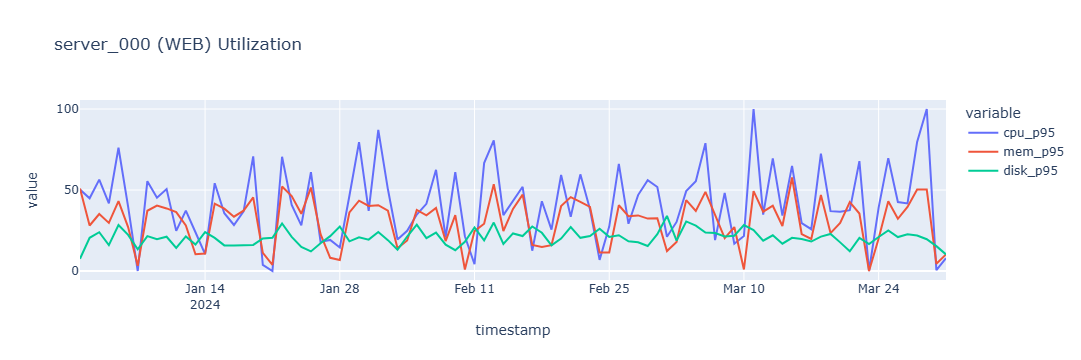


Average P95 Utilization by Archetype:


,cpu_p95,mem_p95,disk_p95
server_type,,,
application,43.877,46.805,29.604
batch,27.306,44.811,42.249
database,29.415,60.331,55.156
web,38.896,29.833,20.275


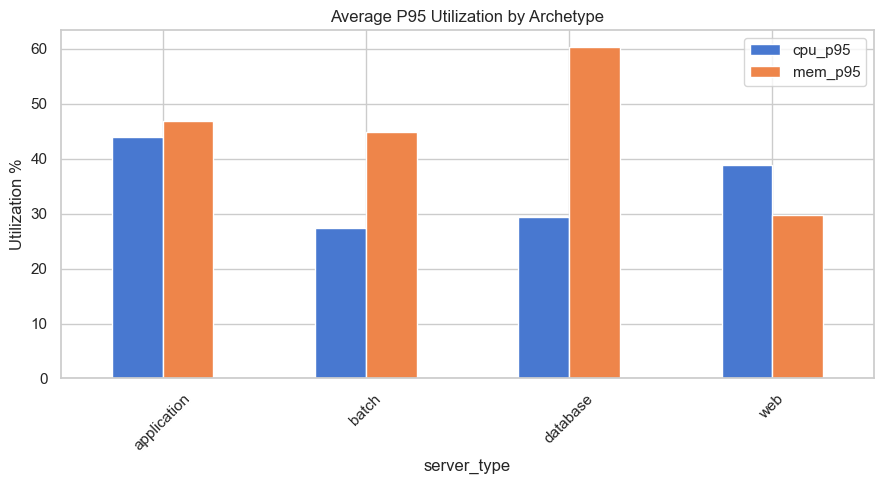

In [11]:
# Step 2_8: Quick inspection plots (FIXED)
# Get first server from our generated data
first_server_id = list(archetype_assignments.keys())[0]
first_archetype = archetype_assignments[first_server_id]

server_sample = df[df['server_id'] == first_server_id].copy()

fig = px.line(
    server_sample,
    x=server_sample.index,
    y=['cpu_p95', 'mem_p95', 'disk_p95'],
    title=f"{first_server_id} ({first_archetype.upper()}) Utilization"
)
fig.show()

# Archetype comparison (average CPU by type)
print("\nAverage P95 Utilization by Archetype:")
archetype_stats = df.groupby('server_type')[['cpu_p95', 'mem_p95', 'disk_p95']].mean()
display(archetype_stats)

archetype_stats[['cpu_p95', 'mem_p95']].plot(kind='bar', figsize=(9,5))
plt.title("Average P95 Utilization by Archetype")
plt.ylabel("Utilization %")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Step 2_9: Save dataset (optional)
from pathlib import Path

output_dir = PROJECT_ROOT / "data" / "synthetic"
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / "notebook_generated.csv.gz"

# Save with compression
df.to_csv(output_path, compression='gzip')

print(f"✅ Dataset saved to: {output_path}")
print(f"   File size: {output_path.stat().st_size / 1024:.2f} KB")
print(f"   Records: {len(df):,}")
print(f"   Columns: {df.shape[1]}")
print(f"\n🎉 Data generation complete!")
print(f"\nTo load this data later:")
print(f"   df = pd.read_csv('{output_path}', compression='gzip', parse_dates=['timestamp'], index_col='timestamp')")

✅ Dataset saved to: C:\pyproj\AWS-CapacityForecaster\data\synthetic\notebook_generated.csv.gz
   File size: 17.70 KB
   Records: 910
   Columns: 18

🎉 Data generation complete!

To load this data later:
   df = pd.read_csv('C:\pyproj\AWS-CapacityForecaster\data\synthetic\notebook_generated.csv.gz', compression='gzip', parse_dates=['timestamp'], index_col='timestamp')
